In [10]:
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torchvision
from difflogic import LogicLayer, GroupSum

In [11]:
BATCH_SIZE = 128
GATE_OPTIMIZER = 'sparsemax'
NETWORK_OPTIMIZER_LR = 0.01
GUMBEL_TAU = 0.25
GROUP_SUM_TAU = 100
NETWORK_LAYERS = 8
GATES_PER_NETWORK = 256_000
LOSS = 'cross_entropy'
EPOCHS = 20
SUB_EPOCHS = 50 ## total epochs = 20*50 = 1000
                

In [12]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    LogicLayer(3072,GATES_PER_NETWORK,device='cuda',implementation='cuda',gate_function=GATE_OPTIMIZER,gumbel_tau=GUMBEL_TAU),
    LogicLayer(GATES_PER_NETWORK,GATES_PER_NETWORK,device='cuda',implementation='cuda',gate_function=GATE_OPTIMIZER,gumbel_tau=GUMBEL_TAU),
    LogicLayer(GATES_PER_NETWORK,GATES_PER_NETWORK,device='cuda',implementation='cuda',gate_function=GATE_OPTIMIZER,gumbel_tau=GUMBEL_TAU),
    LogicLayer(GATES_PER_NETWORK,GATES_PER_NETWORK,device='cuda',implementation='cuda',gate_function=GATE_OPTIMIZER,gumbel_tau=GUMBEL_TAU),
    LogicLayer(GATES_PER_NETWORK,GATES_PER_NETWORK,device='cuda',implementation='cuda',gate_function=GATE_OPTIMIZER,gumbel_tau=GUMBEL_TAU),
    LogicLayer(GATES_PER_NETWORK,GATES_PER_NETWORK,device='cuda',implementation='cuda',gate_function=GATE_OPTIMIZER,gumbel_tau=GUMBEL_TAU),
    LogicLayer(GATES_PER_NETWORK,GATES_PER_NETWORK,device='cuda',implementation='cuda',gate_function=GATE_OPTIMIZER,gumbel_tau=GUMBEL_TAU),
    GroupSum(10,tau=GROUP_SUM_TAU)
)

In [13]:
dataset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,
                                       transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))

trainloader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True)

test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                         transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))

val_ds, test_ds = torch.utils.data.random_split(test_ds,[9000,1000])

val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=1000, shuffle=False,pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True
)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
path = ''
if GATE_OPTIMIZER == 'gumbel_softmax':
    path = f'./checkpoints/logicnet_cifar_10_gumbel_softmax_tau={GUMBEL_TAU}_l{NETWORK_LAYERS}_g-{GATES_PER_NETWORK}'
if GATE_OPTIMIZER == 'softmax':
    path = f'./checkpoints/logicnet_cifar_10_softmax_l{NETWORK_LAYERS}_g-{GATES_PER_NETWORK}'
if GATE_OPTIMIZER == 'sparsemax':
    path = f'./checkpoints/logicnet_cifar_10_sparsemax_l{NETWORK_LAYERS}_g-{GATES_PER_NETWORK}'


In [15]:
path

'./checkpoints/logicnet_cifar_10_sparsemax_l8_g-256000'

In [16]:
def validation_check(model):
    criterion = torch.nn.CrossEntropyLoss()
    correct = 0
    n = 0
    loss = 0
    with torch.no_grad():
        for x,y in val_loader:
            x = x.to('cuda',non_blocking=True)
            y = y.to('cuda',non_blocking=True)
            logits = model(x)
            loss += criterion(logits,y).detach().item()
            correct += (logits.argmax(dim=1) == y).sum().item()
            n += 1
    loss = loss/n
    acc = correct/len(val_ds)
    return loss,acc
    


In [17]:
loss_epoch = []
opt_step_loss = []
validation_loss_acc_per_epoch = []


In [18]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=NETWORK_OPTIMIZER_LR)  # difflogic recommends 0.01
device = torch.device('cuda')
model.train()
for i in range(EPOCHS+1):
    for epoch in range(1,20+1):
        for x, y in trainloader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            opt_step_loss.append(loss.detach().item())
            loss.backward()
            optimizer.step()
        loss_epoch.append(opt_step_loss[-1])
        val_loss,val_acc = validation_check(model)
        validation_loss_acc_per_epoch.append((val_loss,val_acc))
        print(f"Epoch {(epoch)+(i*20)} done,  Epoch loss = {loss_epoch[-1]}, validation loss = {val_loss}, val acc = {val_acc}")
    checkpoint_path = f"{path}_epoch-{i*epoch}.pth"


    

Epoch 1 done,  Epoch loss = 4785.4482421875, validation loss = 11529835.495225694, val acc = 0.2848888888888889


KeyboardInterrupt: 

In [127]:

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=NETWORK_OPTIMIZER_LR)  # difflogic recommends 0.01
device = torch.device('cuda')
model.train()
for i in range(EPOCHS+1):
    for epoch in range(1,20+1):
        for x, y in trainloader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            opt_step_loss.append(loss.detach().item())
            loss.backward()
            optimizer.step()
        loss_epoch.append(opt_step_loss[-1])
        val_loss,val_acc = validation_check(model)
        validation_loss_acc_per_epoch.append((val_loss,val_acc))
        print(f"Epoch {(epoch)+(i*20)} done,  Epoch loss = {loss_epoch[-1]}, validation loss = {val_loss}, val acc = {val_acc}")
    checkpoint_path = f"{path}_epoch-{i*epoch}.pth"
    torch.save(model.state_dict(), checkpoint_path)

Epoch 1 done,  Epoch loss = 2.104917526245117, validation loss = 2.034108135435316, val acc = 0.2981111111111111
Epoch 2 done,  Epoch loss = 1.8806991577148438, validation loss = 1.8525413937038846, val acc = 0.35644444444444445
Epoch 3 done,  Epoch loss = 1.9608170986175537, validation loss = 1.7767474916246202, val acc = 0.39011111111111113
Epoch 4 done,  Epoch loss = 1.8080854415893555, validation loss = 1.7443405124876235, val acc = 0.4076666666666667
Epoch 5 done,  Epoch loss = 1.676804542541504, validation loss = 1.7209314240349665, val acc = 0.4128888888888889
Epoch 6 done,  Epoch loss = 1.563296914100647, validation loss = 1.6849487490124173, val acc = 0.4288888888888889
Epoch 7 done,  Epoch loss = 1.8448625802993774, validation loss = 1.6776766114764743, val acc = 0.43755555555555553
Epoch 8 done,  Epoch loss = 1.6365892887115479, validation loss = 1.6729631556404962, val acc = 0.44166666666666665
Epoch 9 done,  Epoch loss = 1.5606714487075806, validation loss = 1.664032260576

KeyboardInterrupt: 

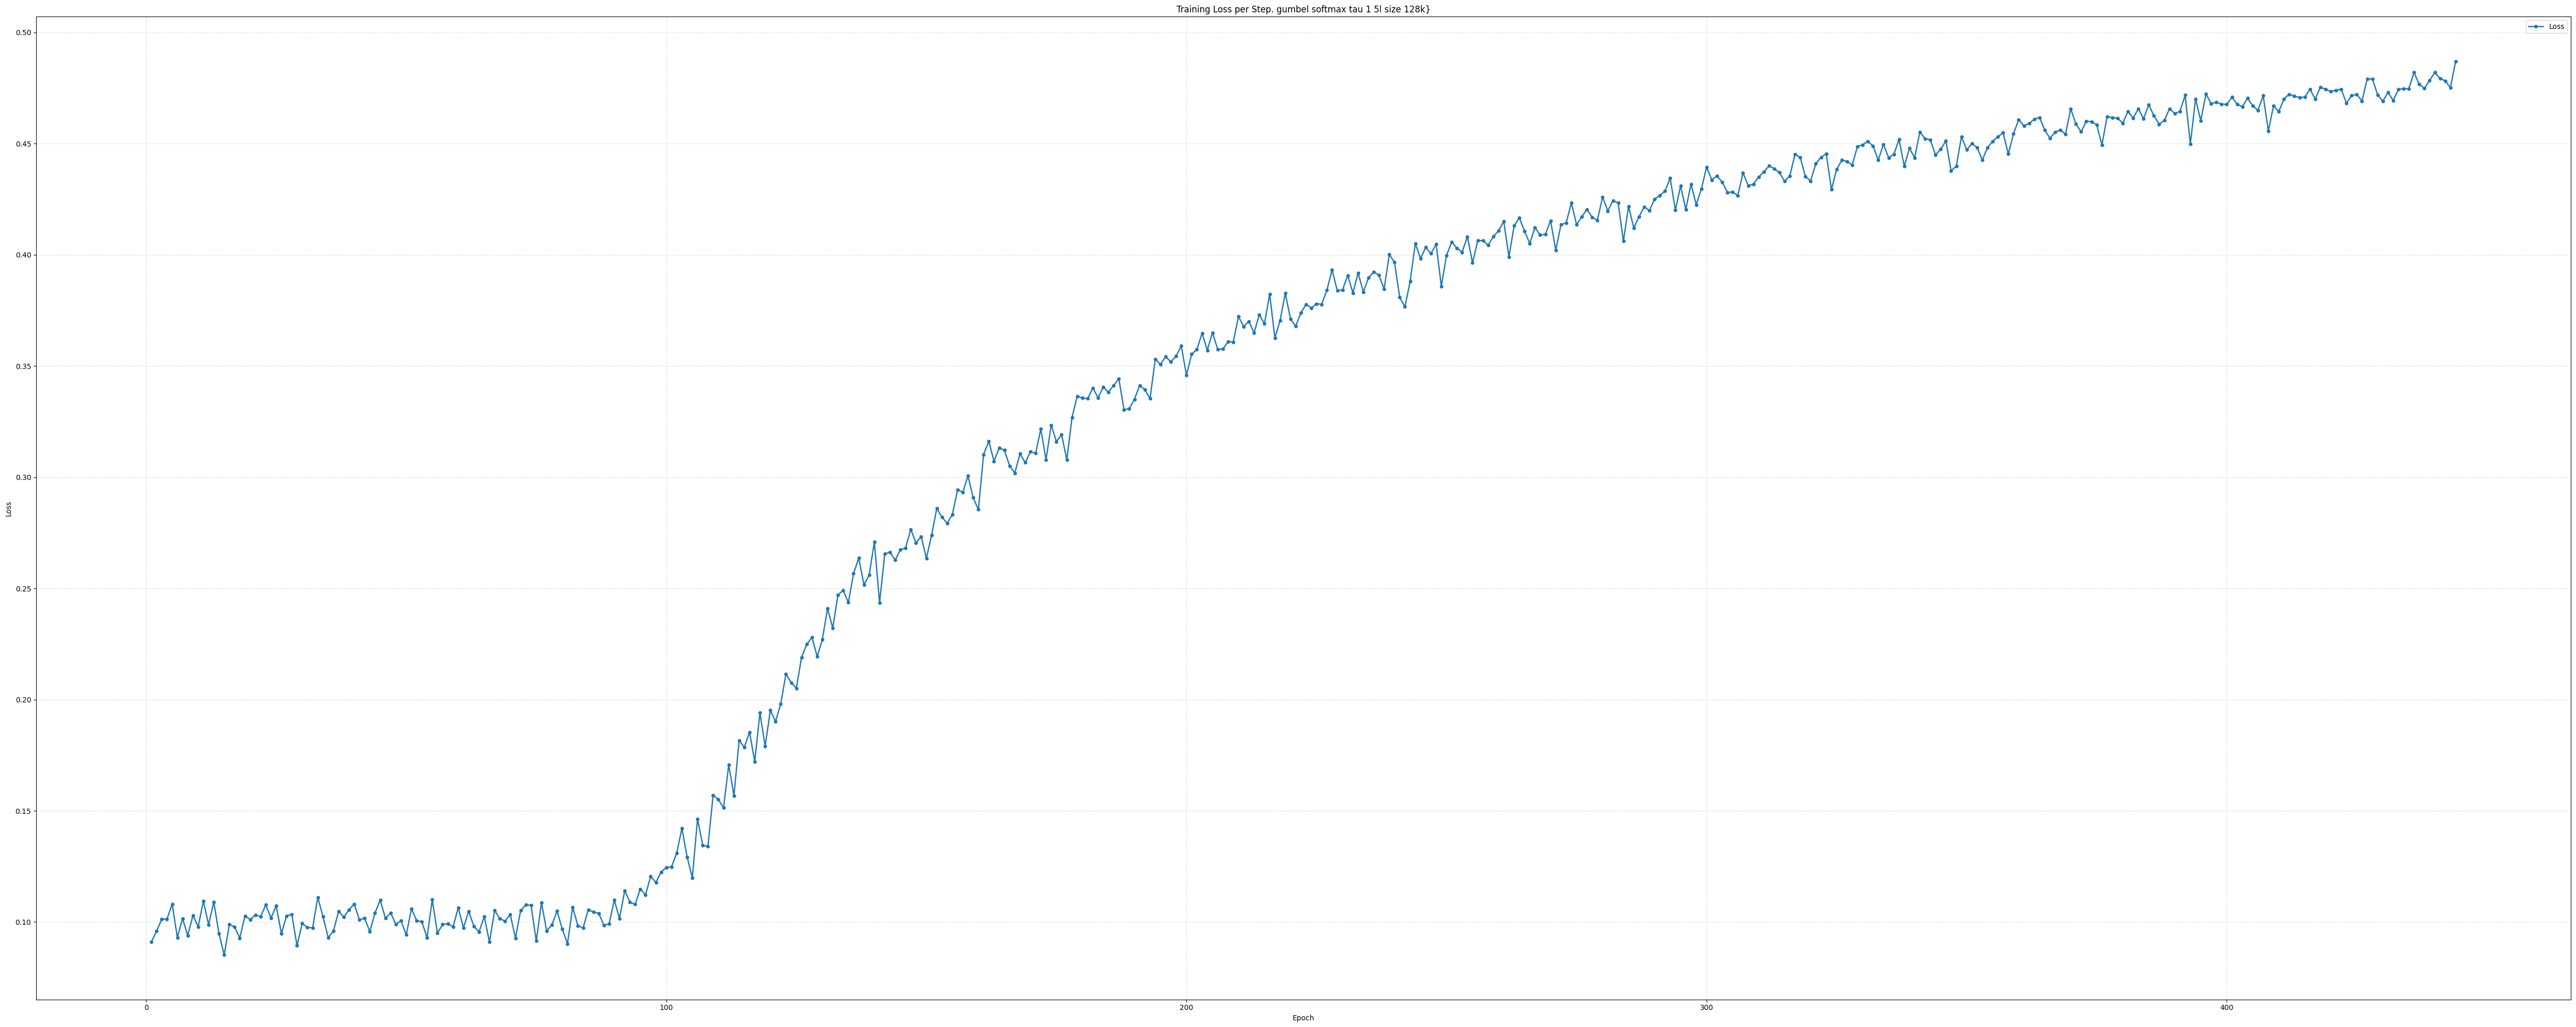

In [54]:
import matplotlib.pyplot as plt
import numpy as np

steps = np.arange(1, len(val_acc_l) + 1)

plt.figure(figsize=(50, 20))
plt.plot(steps,val_acc_l, marker='o', linewidth=1.8, markersize=4, label='Loss')
plt.title('Training Loss per Step. gumbel softmax tau 1 5l size 128k}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

torch.Tensor

In [48]:
val_loss_l = []
val_acc_l = []
for a,b in validation_loss_acc_per_epoch:
    val_loss_l.append(a.detach().item())
    val_acc_l.append(b)
    

In [117]:
from difflogic.packbitstensor import PackBitsTensor
import numpy as np
import time
def packbits_eval(model, loader):
    orig_mode = model.training
    start = time.perf_counter()
    with torch.no_grad():
        model.eval()
        res = np.mean(
            [
                (model(PackBitsTensor(x.to('cuda').reshape(x.shape[0], -1).round().bool())).argmax(-1) == y.to(
                    'cuda')).to(torch.float32).mean().item() 
                for x, y in loader
            ]
        )
        model.train(mode=orig_mode)
    elapsed = time.perf_counter() - start
    throughput = total_images / elapsed
    print(f"throughput : {throughput : .1f}/s")
    
    return res.item()




In [55]:
for x,y in test_loader:
    print(x.reshape(x.shape[0],-1)).round().bool()
    print(x.reshape(x.shape[0],-1))
    break

tensor([[ 0.2392,  0.2471,  0.2941,  ..., -0.0275,  0.0118, -0.1373],
        [ 0.8431,  0.8118,  0.8196,  ...,  0.3961,  0.4980,  0.5608],
        [ 0.2392,  0.2392,  0.0902,  ..., -0.9373, -0.9765, -0.9451],
        ...,
        [ 0.1059, -0.1765, -0.1843,  ..., -0.4902, -0.5137, -0.5294],
        [ 0.6471,  0.6235,  0.6157,  ...,  0.5686,  0.5922,  0.6157],
        [-0.2000, -0.1373,  0.0353,  ...,  0.9216,  0.8824,  0.6314]])


AttributeError: 'NoneType' object has no attribute 'round'

In [118]:
packbits_eval(model,test_loader)

throughput :  22695.7/s


0.10340601056814194

In [4]:
model.load_state_dict(torch.load('/home/ramganeshs/research/src/experiments/checkpoints/logicnet_cifar_10_softmax_l6_g-128000_epoch-2.pth'))

/tmp/ipykernel_16861/500986382.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/ramganeshs/research/src/experiments/checkpoints/lo

<All keys matched successfully>

In [116]:
import torch
import time
from torchvision import datasets
import torchvision.transforms as transforms
model.eval()
torch.cuda.synchronize()

test_ds = datasets.CIFAR10(root='./data', train=False, download=True,
                         transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True
)

torch.cuda.synchronize()

# Timed run with accuracy
total_images = 0
correct = 0

start = time.perf_counter()
with torch.inference_mode():
    for x, y in test_loader:
        x = x.to('cuda', non_blocking=True)
        y = y.to('cuda', non_blocking=True)
        logits = model(x)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total_images += x.size(0)

torch.cuda.synchronize()
elapsed = time.perf_counter() - start
throughput = total_images / elapsed
accuracy = correct / total_images
error_rate = 1.0 - accuracy

print(f"Inference throughput (float inputs, eval-mode): {throughput:.1f} images/s")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Error rate: {error_rate*100:.2f}%")


model.train()
torch.cuda.synchronize()

test_ds = datasets.CIFAR10(root='./data', train=False, download=True,
                         transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True
)

torch.cuda.synchronize()

# Timed run with accuracy
total_images = 0
correct = 0

start = time.perf_counter()
with torch.inference_mode():
    for x, y in test_loader:
        x = x.to('cuda', non_blocking=True)
        y = y.to('cuda', non_blocking=True)
        logits = model(x)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total_images += x.size(0)

torch.cuda.synchronize()
elapsed = time.perf_counter() - start
throughput = total_images / elapsed
accuracy = correct / total_images
error_rate = 1.0 - accuracy

print(f"Inference throughput (float inputs, eval-mode): {throughput:.1f} images/s")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Error rate: {error_rate*100:.2f}%")

Files already downloaded and verified
Inference throughput (float inputs, eval-mode): 22204.0 images/s
Accuracy: 30.68%
Error rate: 69.32%
Files already downloaded and verified
Inference throughput (float inputs, eval-mode): 22864.8 images/s
Accuracy: 42.48%
Error rate: 57.52%


In [128]:
import torch
import time
from torchvision import datasets
import torchvision.transforms as transforms
model.eval()
torch.cuda.synchronize()

test_ds = datasets.CIFAR10(root='./data', train=False, download=True,
                         transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True
)

torch.cuda.synchronize()

# Timed run with accuracy
total_images = 0
correct = 0

start = time.perf_counter()
with torch.inference_mode():
    for x, y in test_loader:
        x = x.to('cuda', non_blocking=True)
        y = y.to('cuda', non_blocking=True)
        logits = model(x)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total_images += x.size(0)

torch.cuda.synchronize()
elapsed = time.perf_counter() - start
throughput = total_images / elapsed
accuracy = correct / total_images
error_rate = 1.0 - accuracy

print(f"Inference throughput (float inputs, eval-mode): {throughput:.1f} images/s")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Error rate: {error_rate*100:.2f}%")


model.train()
torch.cuda.synchronize()

test_ds = datasets.CIFAR10(root='./data', train=False, download=True,
                         transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=1024, shuffle=False, num_workers=4, pin_memory=True
)

torch.cuda.synchronize()

# Timed run with accuracy
total_images = 0
correct = 0

start = time.perf_counter()
with torch.inference_mode():
    for x, y in test_loader:
        x = x.to('cuda', non_blocking=True)
        y = y.to('cuda', non_blocking=True)
        logits = model(x)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total_images += x.size(0)

torch.cuda.synchronize()
elapsed = time.perf_counter() - start
throughput = total_images / elapsed
accuracy = correct / total_images
error_rate = 1.0 - accuracy

print(f"Inference throughput (float inputs, eval-mode): {throughput:.1f} images/s")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Error rate: {error_rate*100:.2f}%")

Files already downloaded and verified
Inference throughput (float inputs, eval-mode): 21430.5 images/s
Accuracy: 29.13%
Error rate: 70.87%
Files already downloaded and verified
Inference throughput (float inputs, eval-mode): 23159.7 images/s
Accuracy: 45.62%
Error rate: 54.38%
